# *BEATS CT reconstruction pipeline*
[TomoPy](https://tomopy.readthedocs.io/en/latest/) reconstruction pipeline for the [BEATS beamline](https://beats-sesame.eu/) of [SESAME](https://www.sesame.org.jo/)

Created on:  23.05.2021 <br />
Last update: 12.06.2023 <br />

- By: [Gianluca Iori](https://github.com/gianthk), 2023
- Code license: MIT
- Narrative license: CC-BY-NC-SA

## Notes

### How to activate a TomoPy kernel in Jupyter:
`conda env list`

`source activate tomopy`

`python -m ipykernel install --user --name tomopy_source --display-name "conda (tomopy_source)"`

`jupyter notebook &`

---
## Configuration and imports

In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
import sys
sys.path.append('./../recon_utils/')

In [3]:
import os
import dxchange
import tomopy
import numpy as np
import h5py
import matplotlib
import matplotlib.pyplot as plt
import logging
import recon_utils as ru

astropy module not found
olefile module not found


In [4]:
matplotlib.rcParams['figure.dpi'] = 300
plt.style.use('ggplot')

In [5]:
logging.basicConfig(level=logging.INFO)

In [6]:
Fiij_exe = '/opt/fiji-linux64/Fiji.app/ImageJ-linux64'
Fiji_exe_stack = Fiij_exe + ' -macro FolderOpener_virtual.ijm '

In [7]:
ncore = 36 # BL-BEATS-WS01
pad_size = 0

## Load experiment data

In [66]:
work_dir = "/mnt/PETRA/SED/BEATS/IH/test-20230613T173609"
work_dir = "/mnt/PETRA/SED/BEATS/IH/test-20230613T164151"
h5file = work_dir+"/test-20230613T173609.h5"
h5file = work_dir+"/test-20230613T164151.h5"
# recon_dir = work_dir+"/recon/"
# recon_dir = "/home/beats/Data/concrete/recon_phase/"
recon_dir = "/home/beats/Data/tmp/test_FLIR/recon/"
# recon_dir_8bit = "/home/beats/Data/concrete/recon_8bit/"
# recon_dir_8bit = work_dir+"/recon_8bit/"
# cor_dir = work_dir+"/cor/"
cor_dir = "/home/beats/Data/tmp/test_FLIR/cor/"

Read the complete dataset

In [9]:
# projs, flats, darks, theta = dxchange.read_aps_32id(h5file, exchange_rank=0)

Read portion of the sinograms

In [67]:
projs, flats, darks, theta = dxchange.read_aps_32id(h5file, exchange_rank=0, sino=(590, 610, 1))

INFO:dxchange.reader:Data successfully imported: /mnt/PETRA/SED/BEATS/IH/test-20230613T164151/test-20230613T164151.h5
INFO:dxchange.reader:Data successfully imported: /mnt/PETRA/SED/BEATS/IH/test-20230613T164151/test-20230613T164151.h5
INFO:dxchange.reader:Data successfully imported: /mnt/PETRA/SED/BEATS/IH/test-20230613T164151/test-20230613T164151.h5
INFO:dxchange.reader:Data successfully imported: /mnt/PETRA/SED/BEATS/IH/test-20230613T164151/test-20230613T164151.h5


In [59]:
import napari

In [60]:
viewer = napari.view_image(projs)

In [11]:
print(projs[:, :, :].shape[:])
print(projs.dtype)

(2001, 20, 1920)
uint16


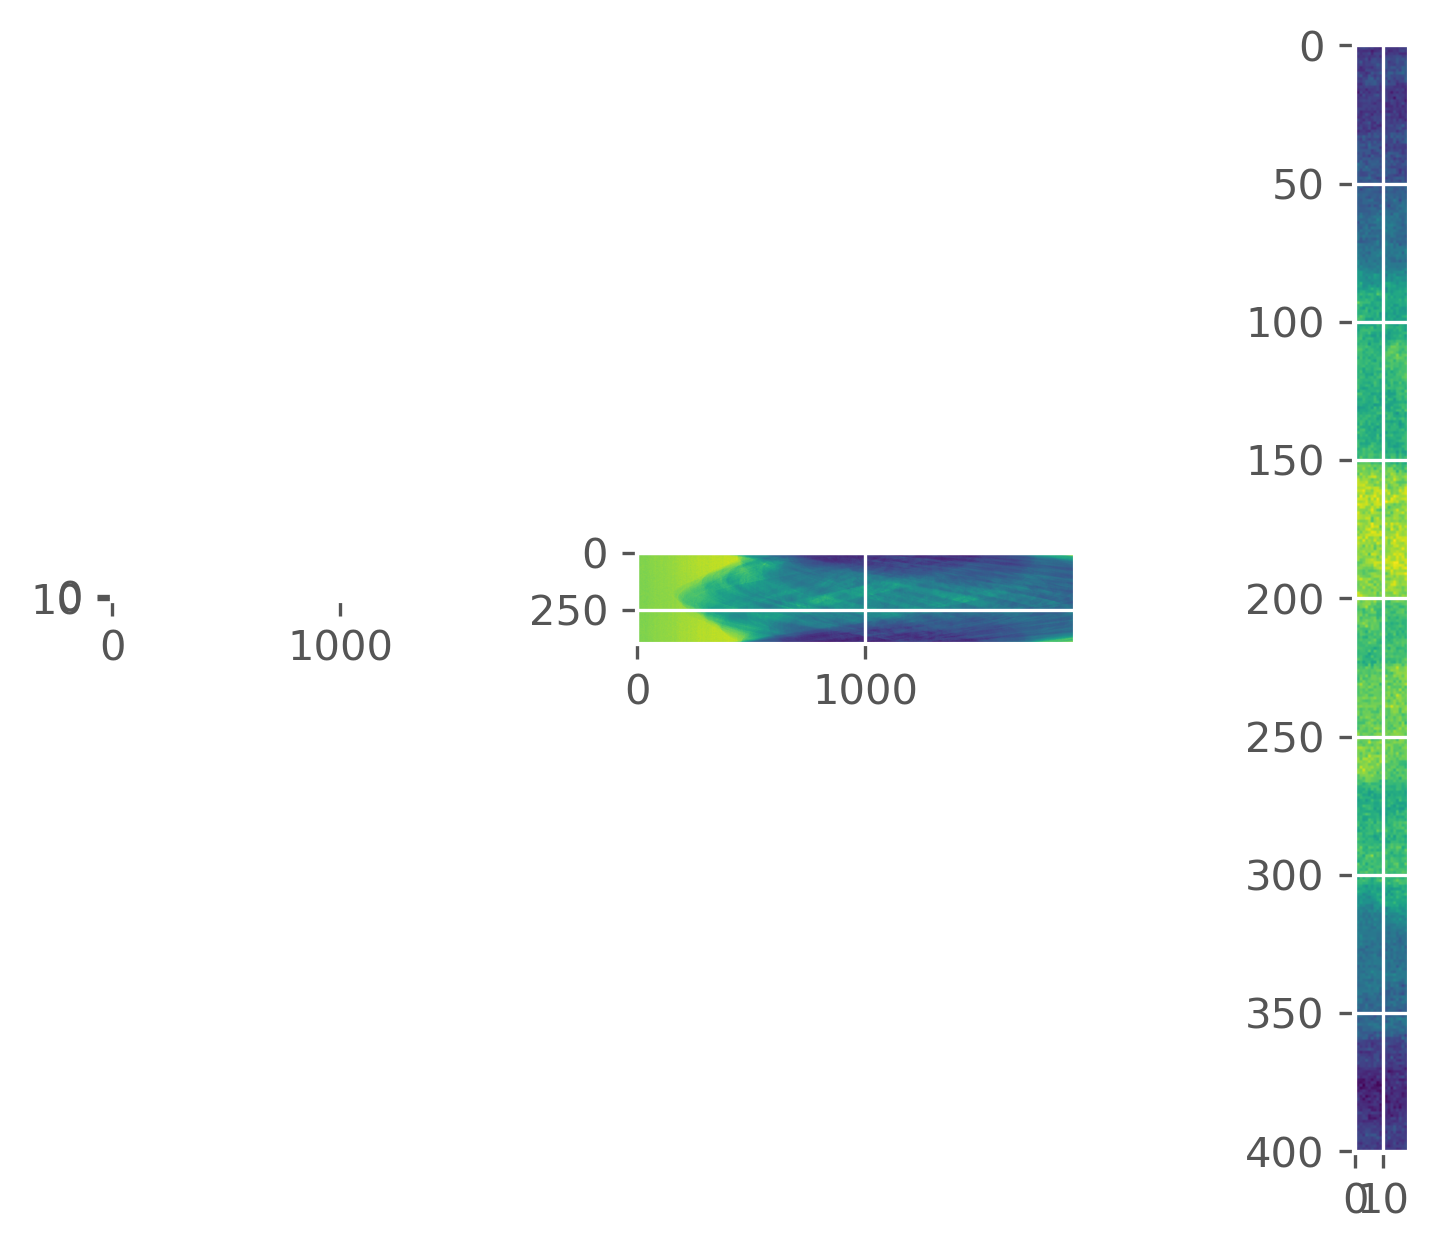

In [11]:
ru.plot_midplanes(projs)

In [10]:
ru.writemidplanes(projs, recon_dir+'/slice_tiff')

If the angular information is not avaialable from the raw data you need to set the data collection angles. In this case, theta is set as equally spaced between 0-180 degrees.

In [68]:
theta2 = tomopy.angles(projs.shape[0])

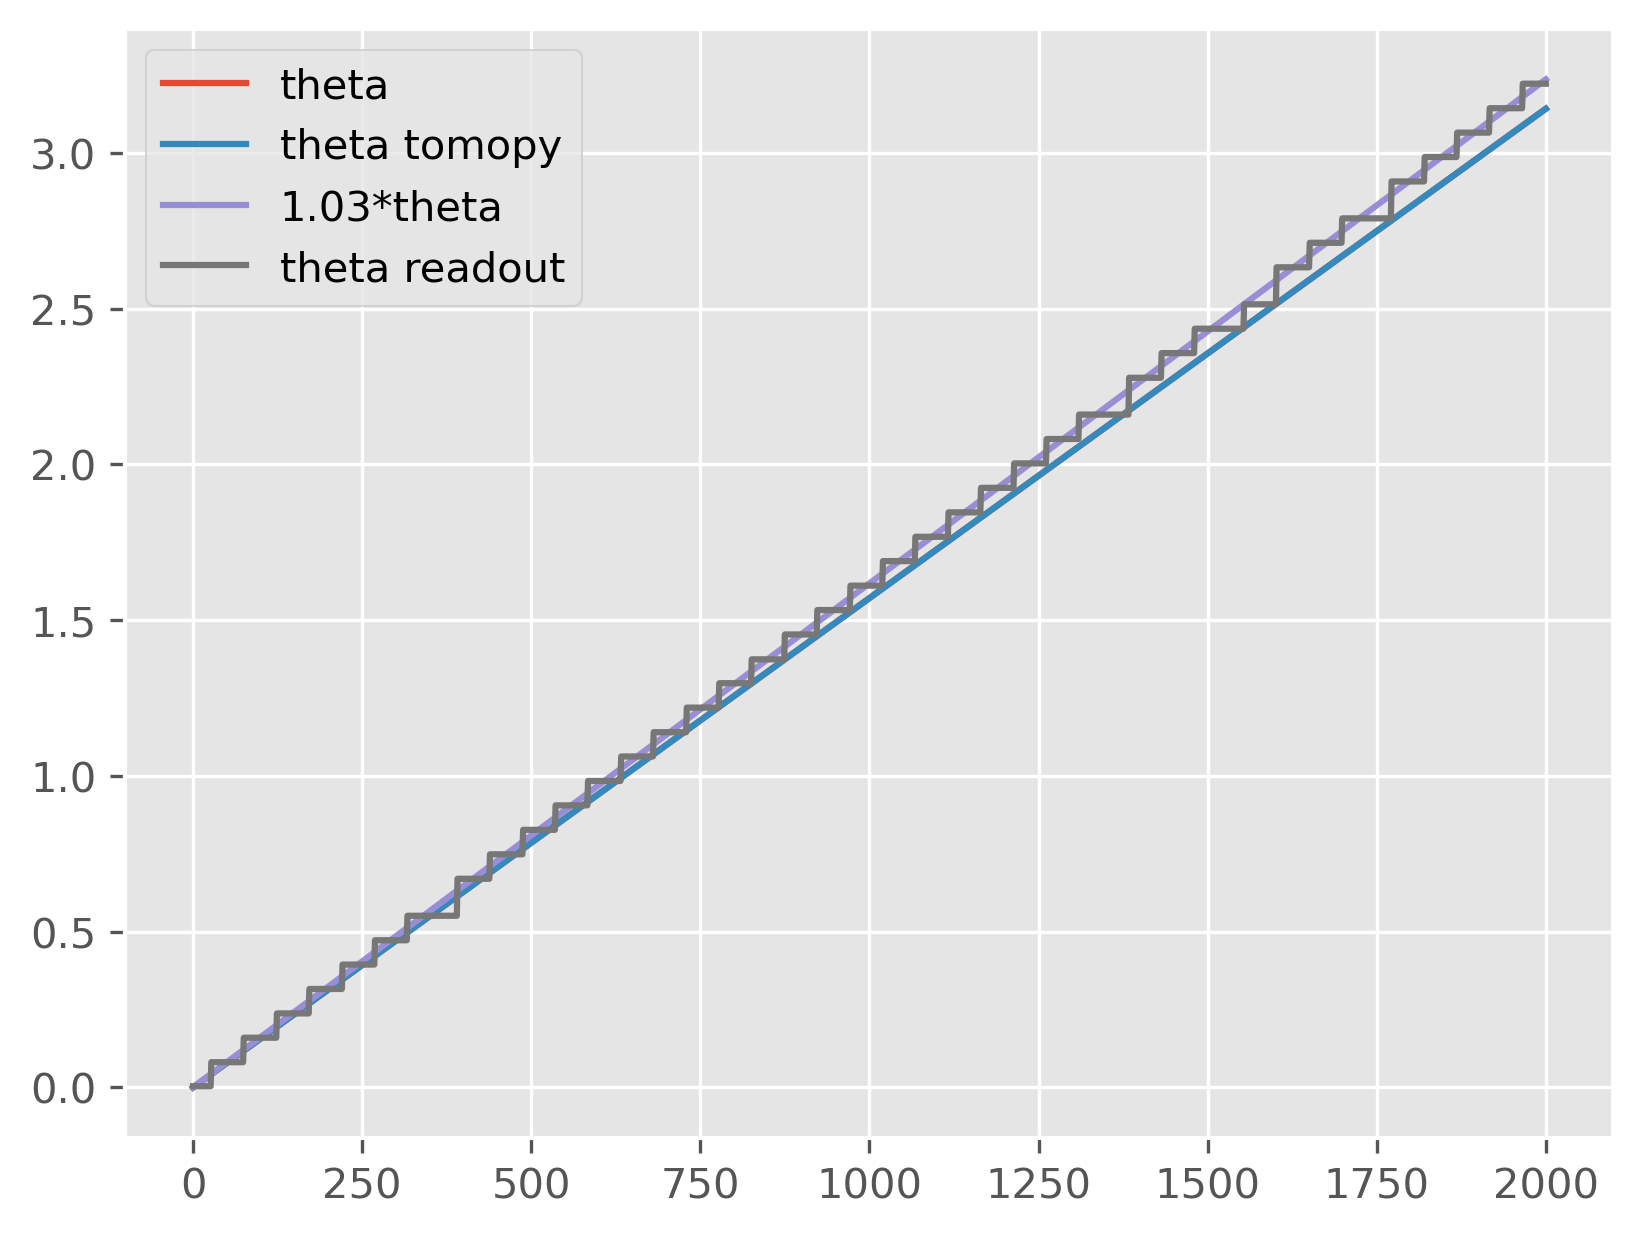

In [71]:
plt.plot(theta, label='theta')
plt.plot(theta2, label='theta tomopy')
plt.plot(1.03*theta, label='1.03*theta')
plt.plot(theta_readout/180*np.pi, label='theta readout')
plt.legend()

In [18]:
if theta is None:
    theta = tomopy.angles(projs.shape[0])

#### Read theta array from encoder readout

In [69]:
theta_readout = dxchange.read_hdf5(h5file, '/exchange/theta_readout')

INFO:dxchange.reader:Data successfully imported: /mnt/PETRA/SED/BEATS/IH/test-20230613T164151/test-20230613T164151.h5


In [12]:
print(theta_readout)

[0.000000e+00 4.500000e-02 9.000000e-02 ... 3.599108e+02 3.599558e+02
 3.600010e+02]


## Flat field correction

In [12]:
# projs = tomopy.normalize(projs, flats, darks, ncore=ncore, averaging='mean') # averaging='mean'
projs = tomopy.normalize(projs, flats, darks, ncore=ncore, averaging='median') # averaging='mean'

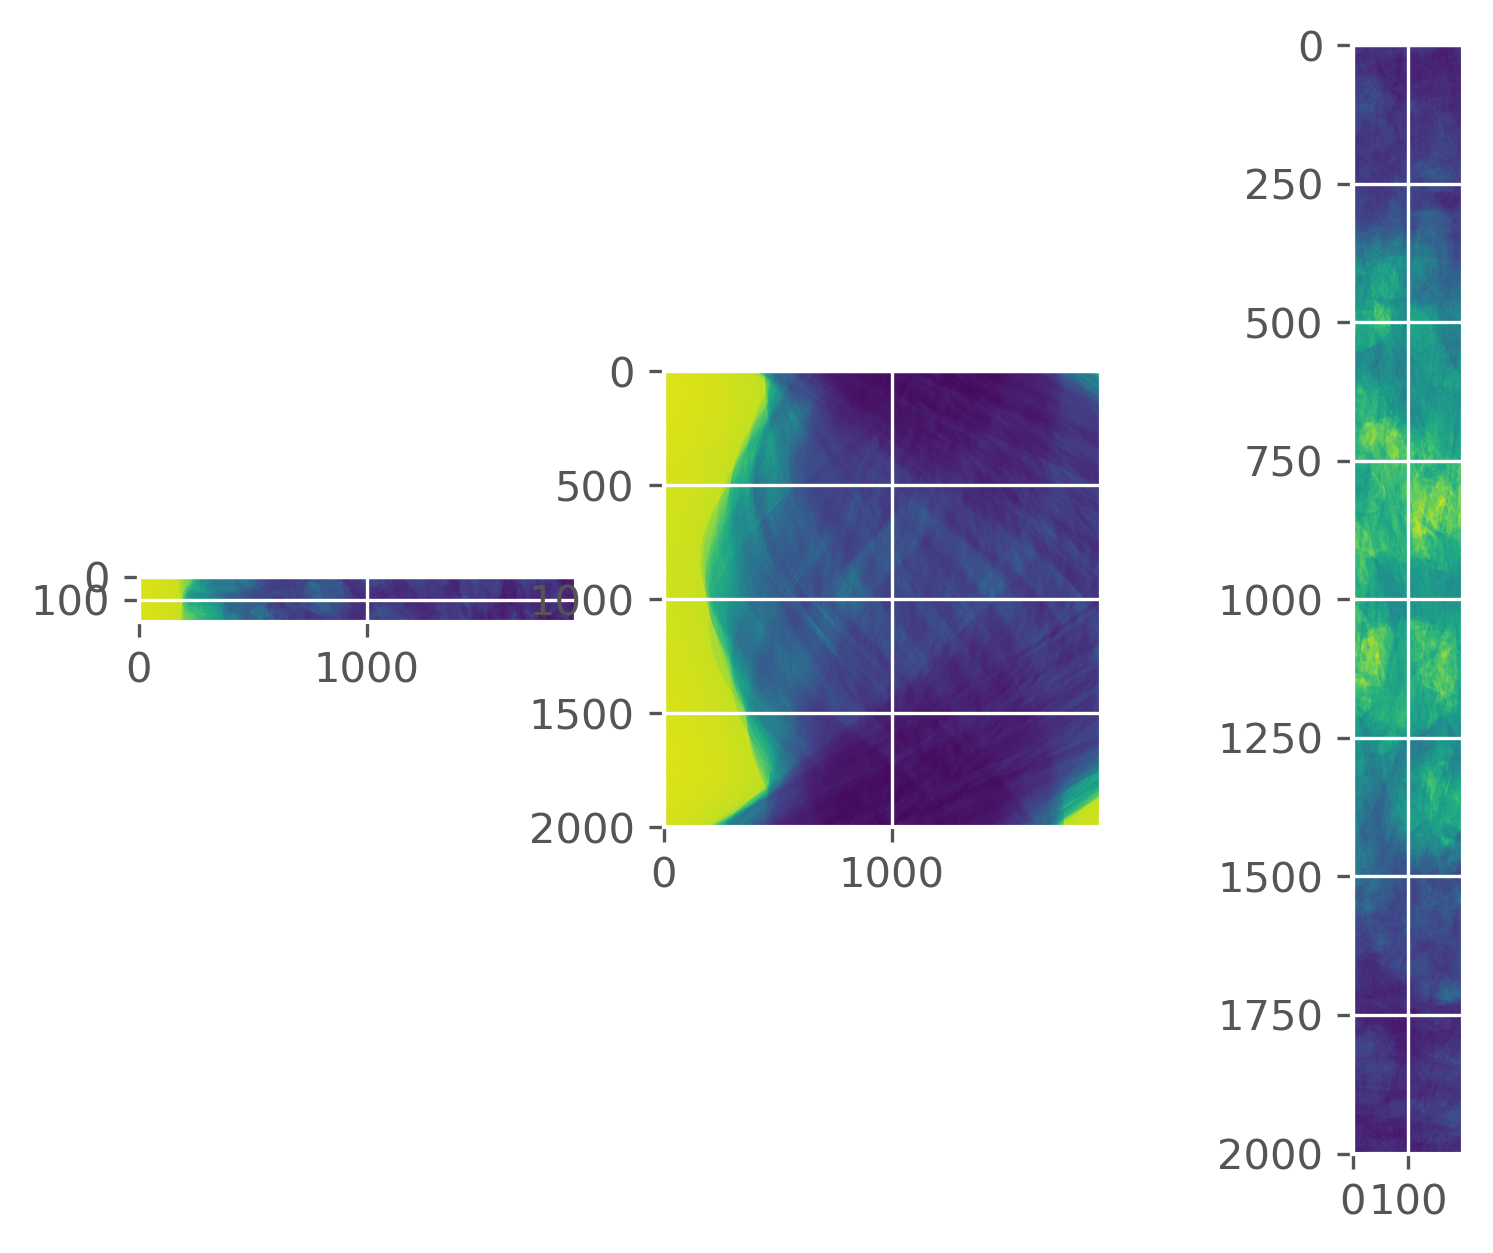

In [13]:
ru.plot_midplanes(projs)

In [12]:
ru.writemidplanes(projs, recon_dir+'/slice_norm')

## Convert from 360 to 180 degree sinograms

In [13]:
projs = tomopy.sino_360_to_180(projs, overlap=700)

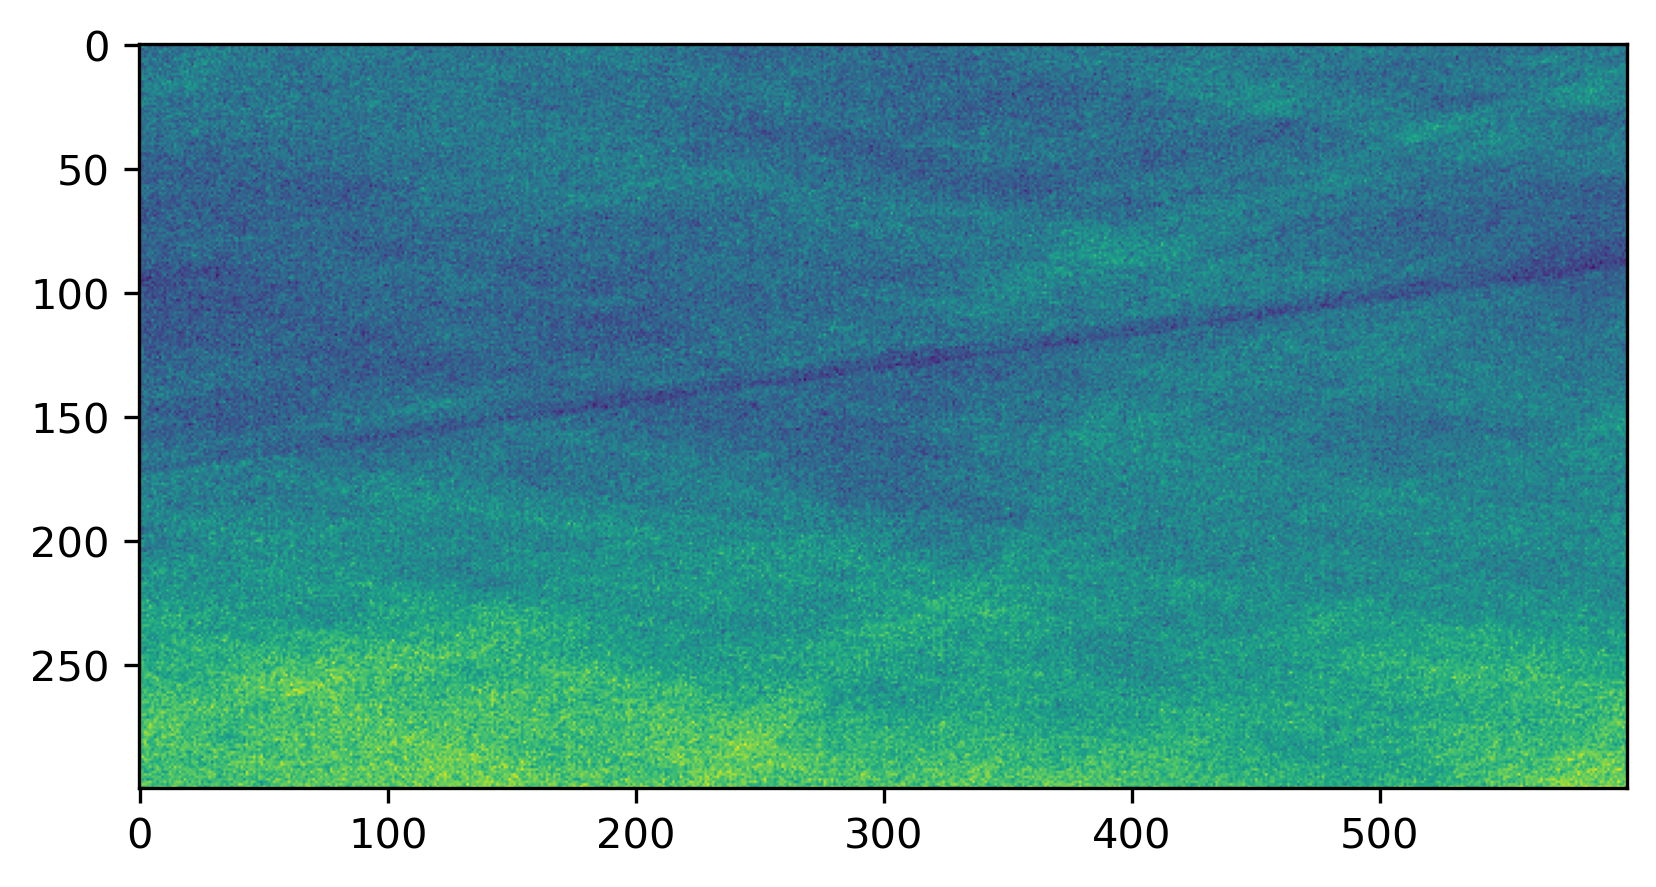

In [22]:
plt.imshow(projs[600:900, 600, 2700:3300])

## Phase retrieval

In [1]:
# import ipywidgets as widgets

In [ ]:
# widgets.IntSlider()

In [ ]:
# widgets.Checkbox(
#     value=False,
#     description='Check me',
#     disabled=False,
#     indent=False
# )

In [15]:
projs_phase = tomopy.retrieve_phase(projs,
                                    pixel_size=1e-4*(6.5/1),
                                    dist=34,
                                    energy=30,
                                    alpha=0.0005,
                                    pad=True,
                                    ncore=ncore,
                                    nchunk=None)

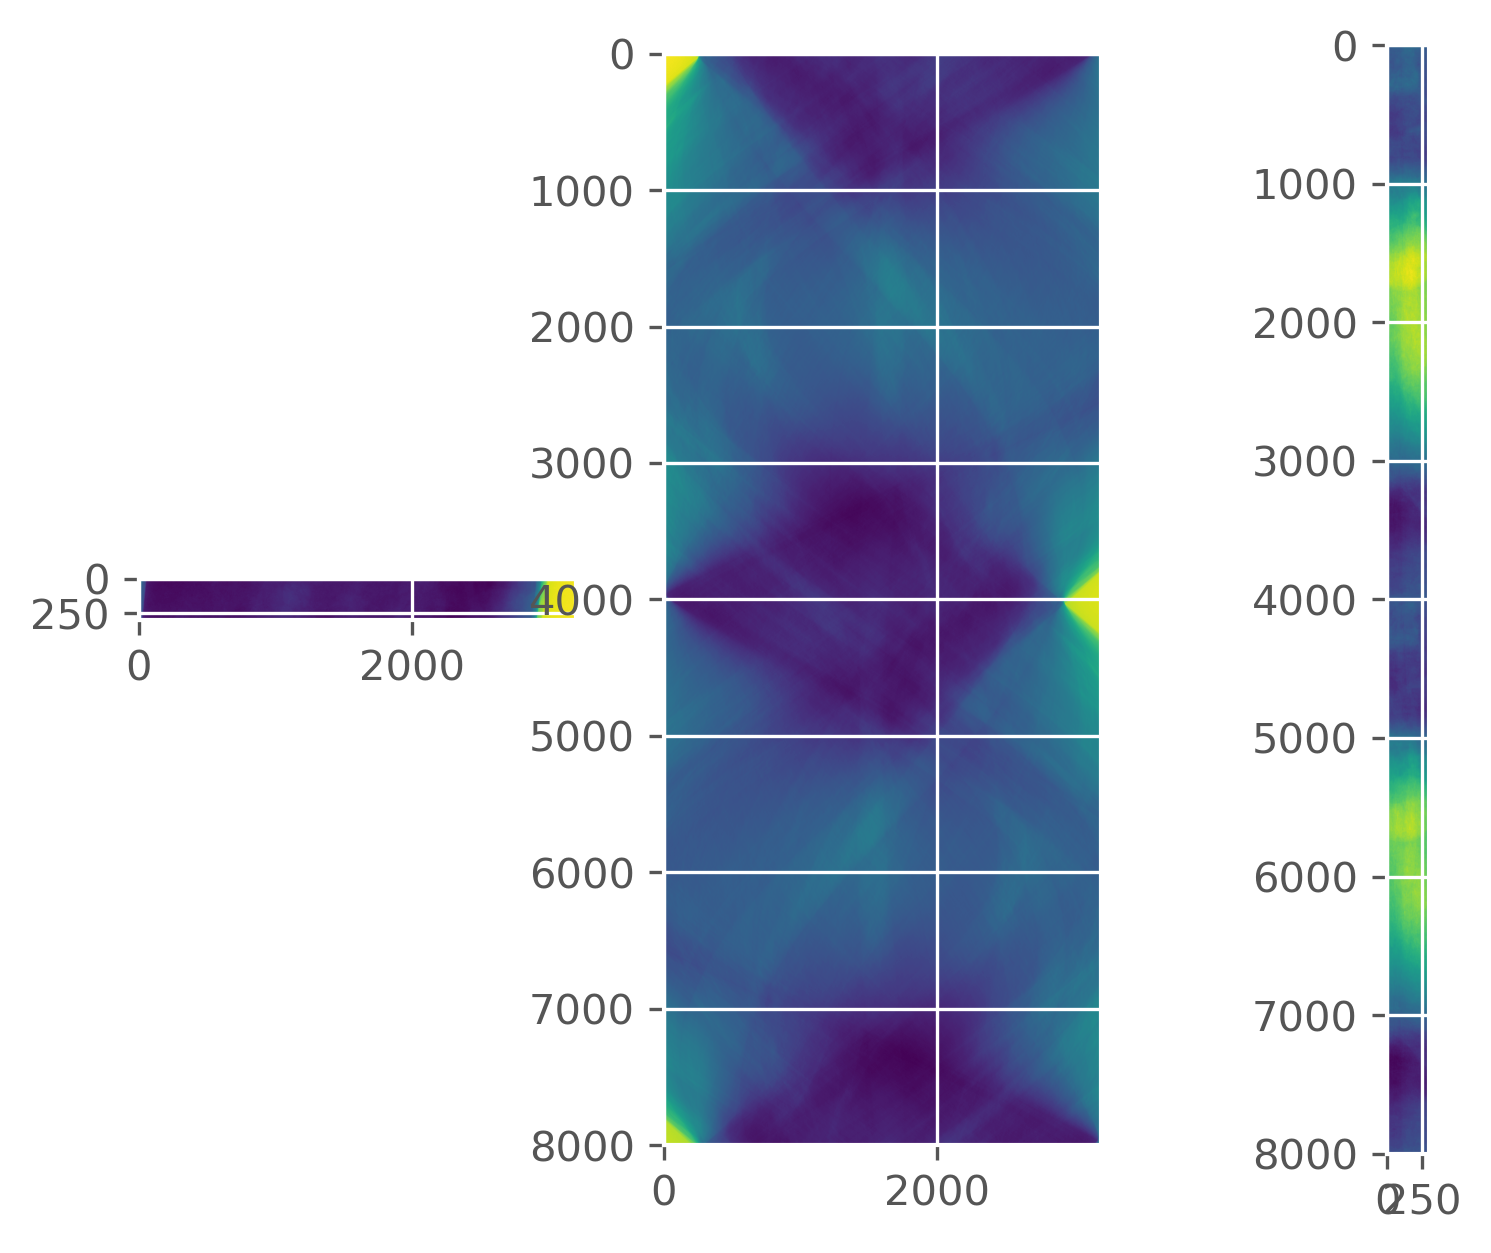

In [16]:
ru.plot_midplanes(projs_phase)

In [126]:
COR = projs_180.shape[2]/2

## Stripe removal
`tomopy.prep.stripe.remove_all_stripe(tomo, snr=3, la_size=61, sm_size=21, dim=1, ncore=None, nchunk=None)`

https://tomopy.readthedocs.io/en/latest/api/tomopy.prep.stripe.html#tomopy.prep.stripe.remove_all_stripe

In [148]:
# projs = tomopy.prep.stripe.remove_dead_stripe(projs, ncore=ncore)

## Log transform
Calculate $ -log(projs) $ to linearize transmission tomography data.

In [13]:
projs = tomopy.minus_log(projs, ncore=ncore)

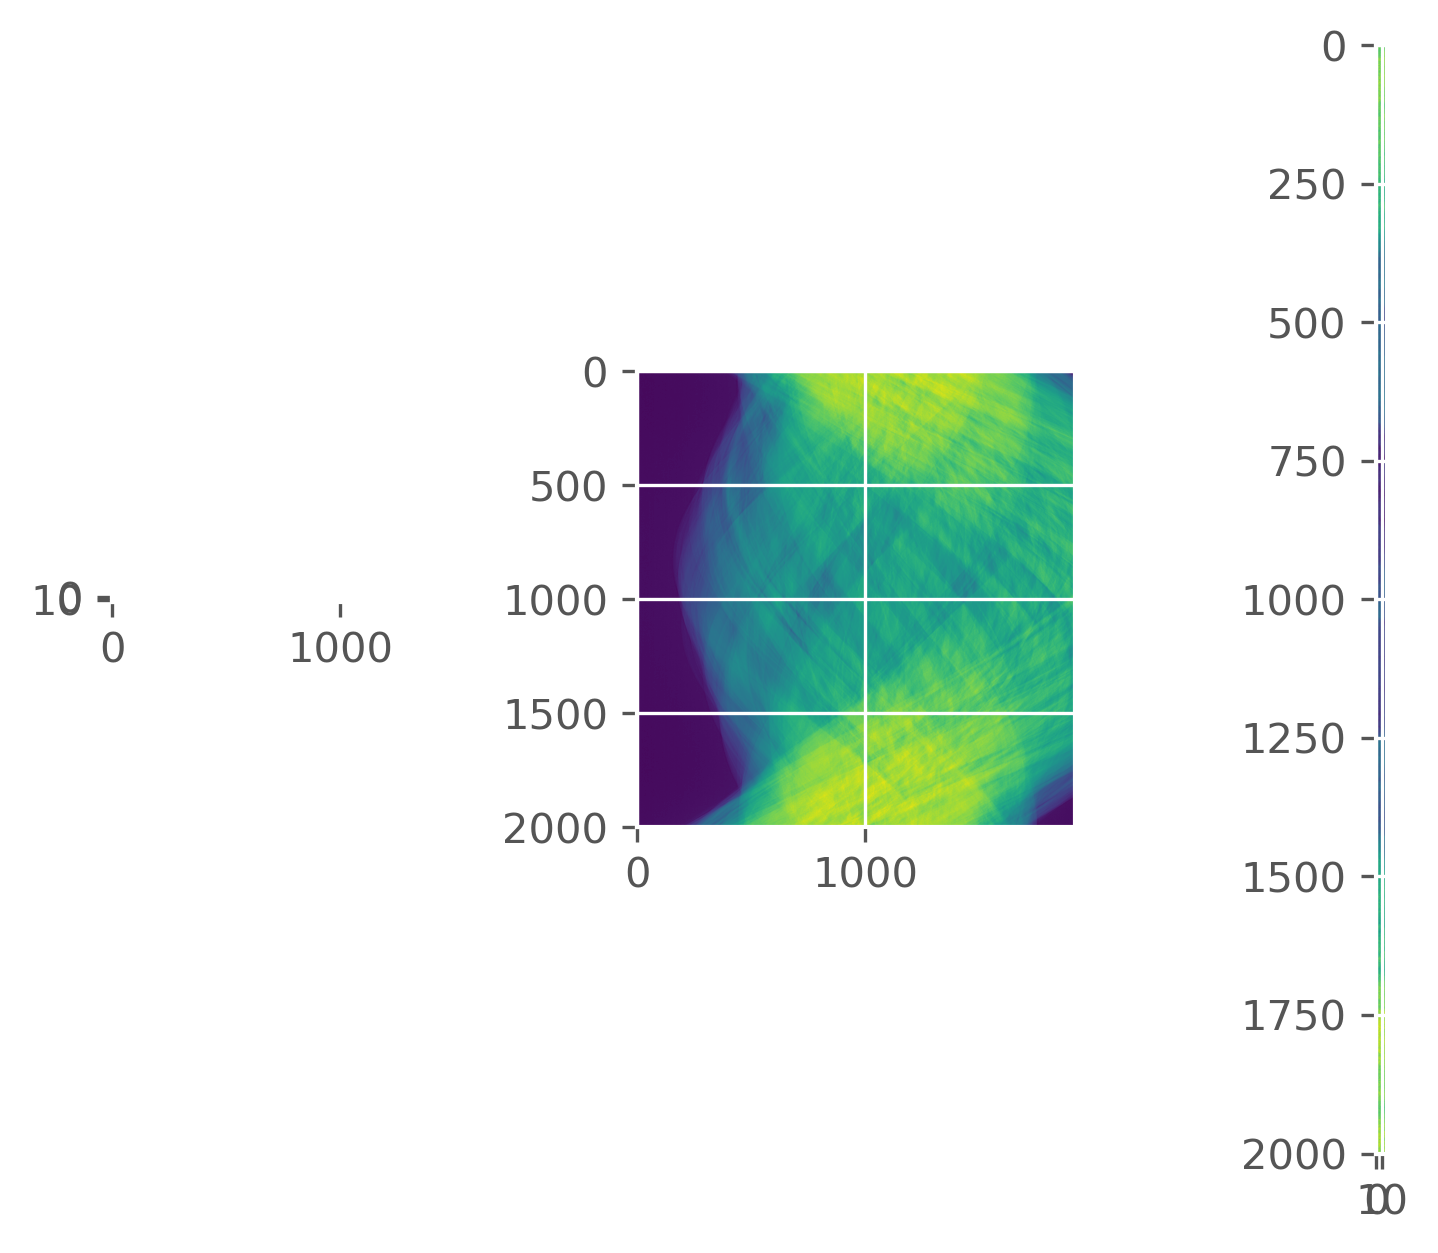

In [15]:
ru.plot_midplanes(projs)

In [14]:
ru.writemidplanes(projs, recon_dir+'/slice_log')

## Center Of Rotation (COR)
### Automatic detect COR

In [15]:
COR = tomopy.find_center_vo(projs[100:,:,:], ncore=ncore)
print(COR)

1016.0


In [20]:
# COR = 1281.75
# COR = 1595.5
COR = 1266.87 # mockup glass high res
COR = 1601.25 # mockup glass low res
COR = 1591.75 # concrete_step
# COR = 1297.75 # grass_fiber
# COR = 1015 # Vo test-20230613T164151 - projs
# COR = 1015 # Vo test-20230613T164151 - projs[100:,:,:]

In [ ]:
# COR = tomopy.find_center(projs, theta, init=projs_crop_corr.shape[2]/2, ind=1000, tol=0.5)
# print(COR)

### Save images reconstructed with COR range

In [47]:
cor_range = [1060, 1130, 1]

In [55]:
tomopy.write_center(projs, 1.03*theta, cor_dir, cor_range)

INFO:tomopy.recon.algorithm:Reconstructing 70 slice groups with 36 master threads...


View them in Fiji

In [64]:
os.system(Fiji_exe_stack + cor_dir+'{:04.2f}'.format(COR[0])+'.tiff &')

0

## Reconstruction

### Data padding

In [51]:
pad_size = 300

In [52]:
projs_pad = tomopy.pad(projs_phase,
                       axis=2,
                       npad=pad_size,
                       mode='constant',
                       ncore=ncore)

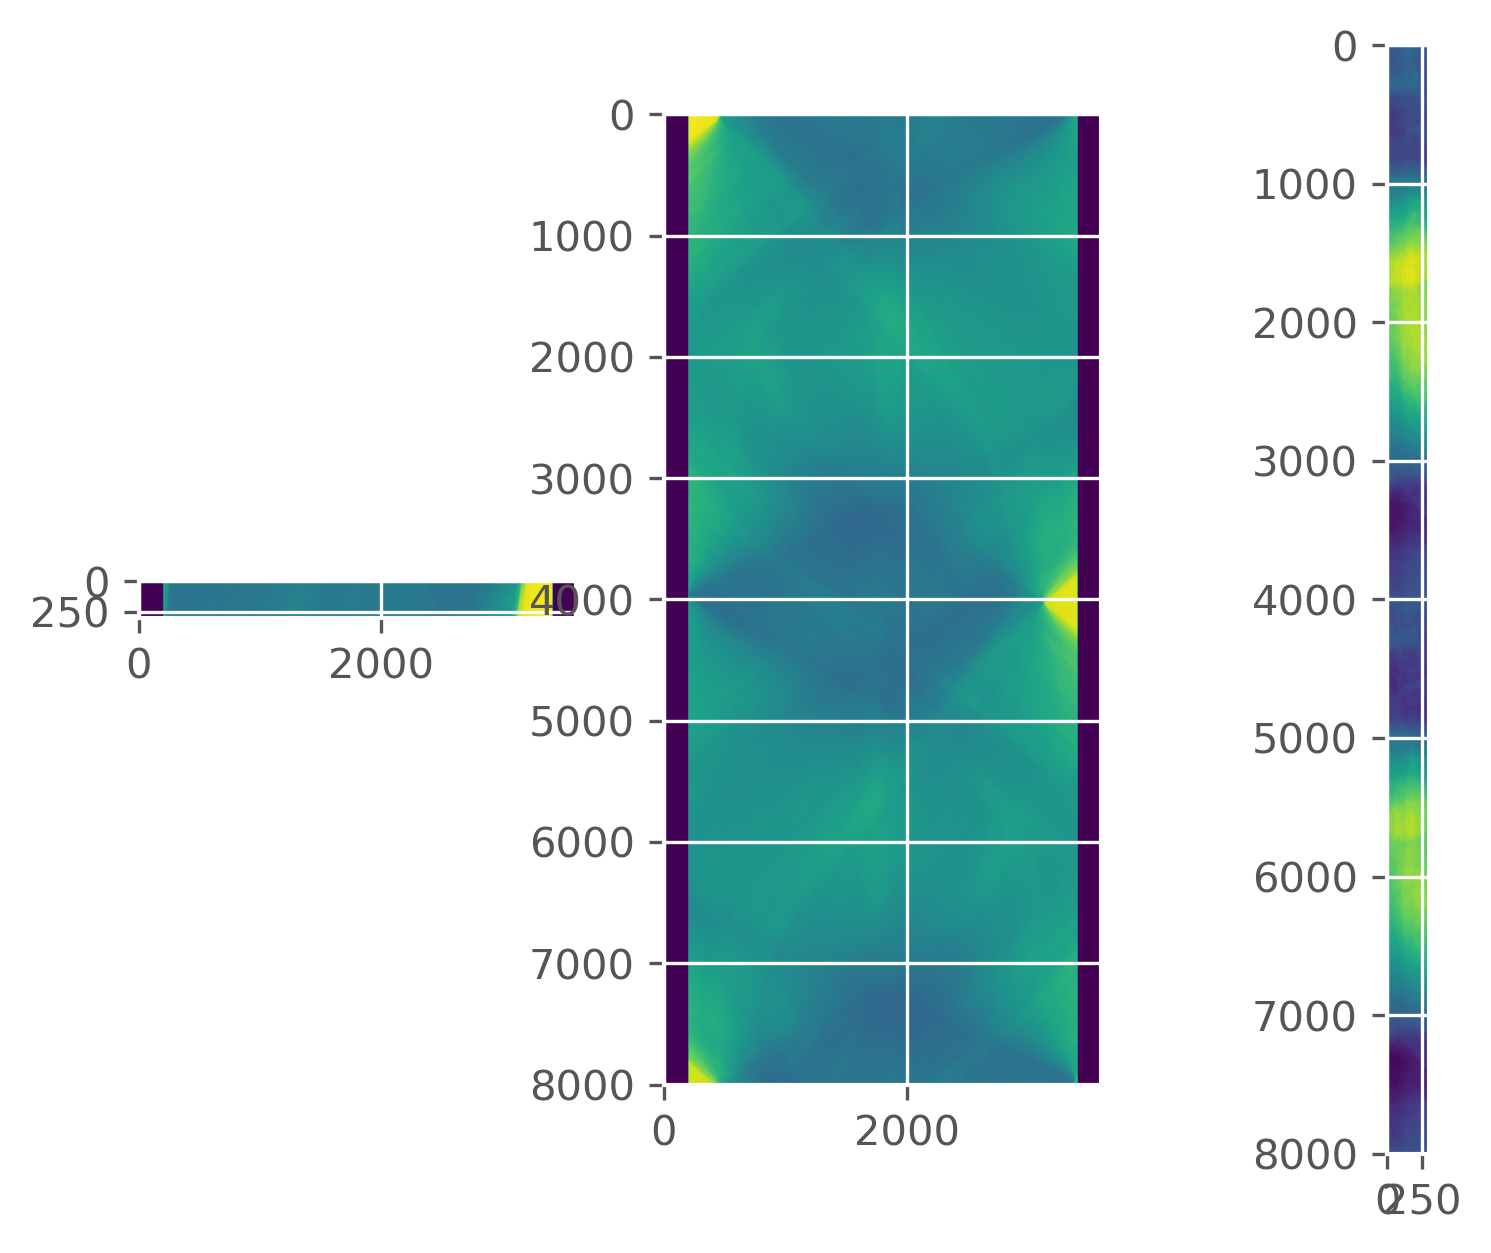

In [28]:
ru.plot_midplanes(projs_pad)

Update COR after padding

In [27]:
COR = projs_pad.shape[2]/2

In [ ]:
# del projs, projs_180
del recon

### Reconstruct and inspect one slice

In [16]:
recon_slice = round(projs.shape[1]/2)
# recon_slice = 200

|  |  |
| :--- | :--- |
| **Algorithm**      | `gridrec` |

In [17]:
recon = tomopy.recon(projs[:, [recon_slice], :],
                     theta,
                     center=COR+pad_size,
                     algorithm='gridrec',
                     sinogram_order=False
                    )

INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


In [ ]:
plt.imshow(recon.squeeze(), cmap='Greys')

|  |  |
| :--- | :--- |
| **Algorithm**      | `fbp CUDA ASTRA` |

In [105]:
options = {'proj_type': 'cuda', 'method': 'FBP_CUDA'}

In [107]:
recon = tomopy.recon([:, [recon_slice], :],
                     theta,
                     center=COR,
                     algorithm=tomopy.astra,
                     options=options
                    )

INFO:tomopy.recon.algorithm:Reconstructing 36 slice groups with 36 master threads...


In [ ]:
plt.imshow(recon[recon_slice,:,:].squeeze(), cmap='Greys')

### CPU reconstruction of the entire dataset
|  |  |
| :--- | :--- |
| **Algorithm**      | `gridrec` |

In [53]:
recon = tomopy.recon(projs_pad,
                     theta,
                     center=COR+pad_size,
                     algorithm='gridrec',
                     sinogram_order=False,
                     ncore=ncore)

INFO:tomopy.recon.algorithm:Reconstructing 36 slice groups with 36 master threads...


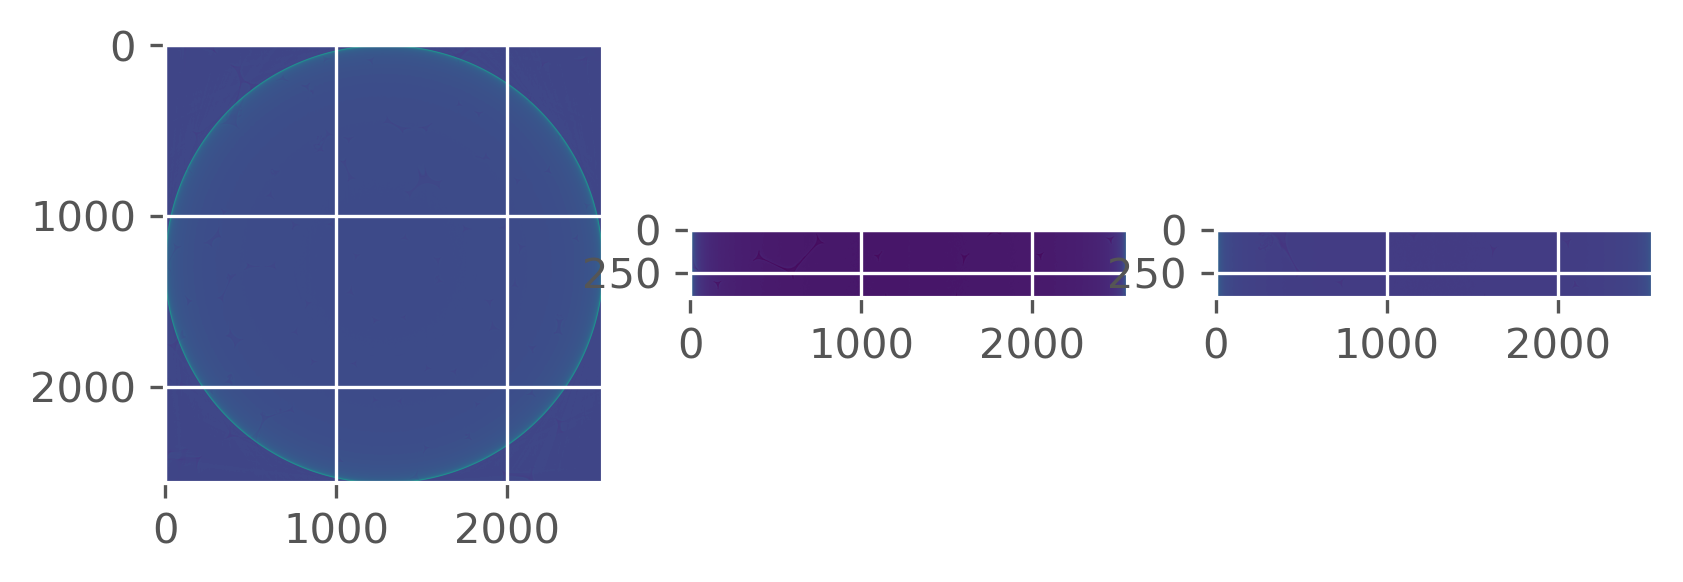

In [93]:
ru.plot_midplanes(recon)

### GPU reconstruction with the ASTRA toolbox
|  |  |
| :--- | :--- |
| **Algorithm**      | `fbp CUDA ASTRA` |

In [117]:
options = {'proj_type': 'cuda', 'method': 'FBP_CUDA'}

In [119]:
recon = tomopy.recon(projs,
                     theta,
                     center=COR,
                     algorithm=tomopy.astra,
                     options=options,
                     ncore=1
                    )

INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


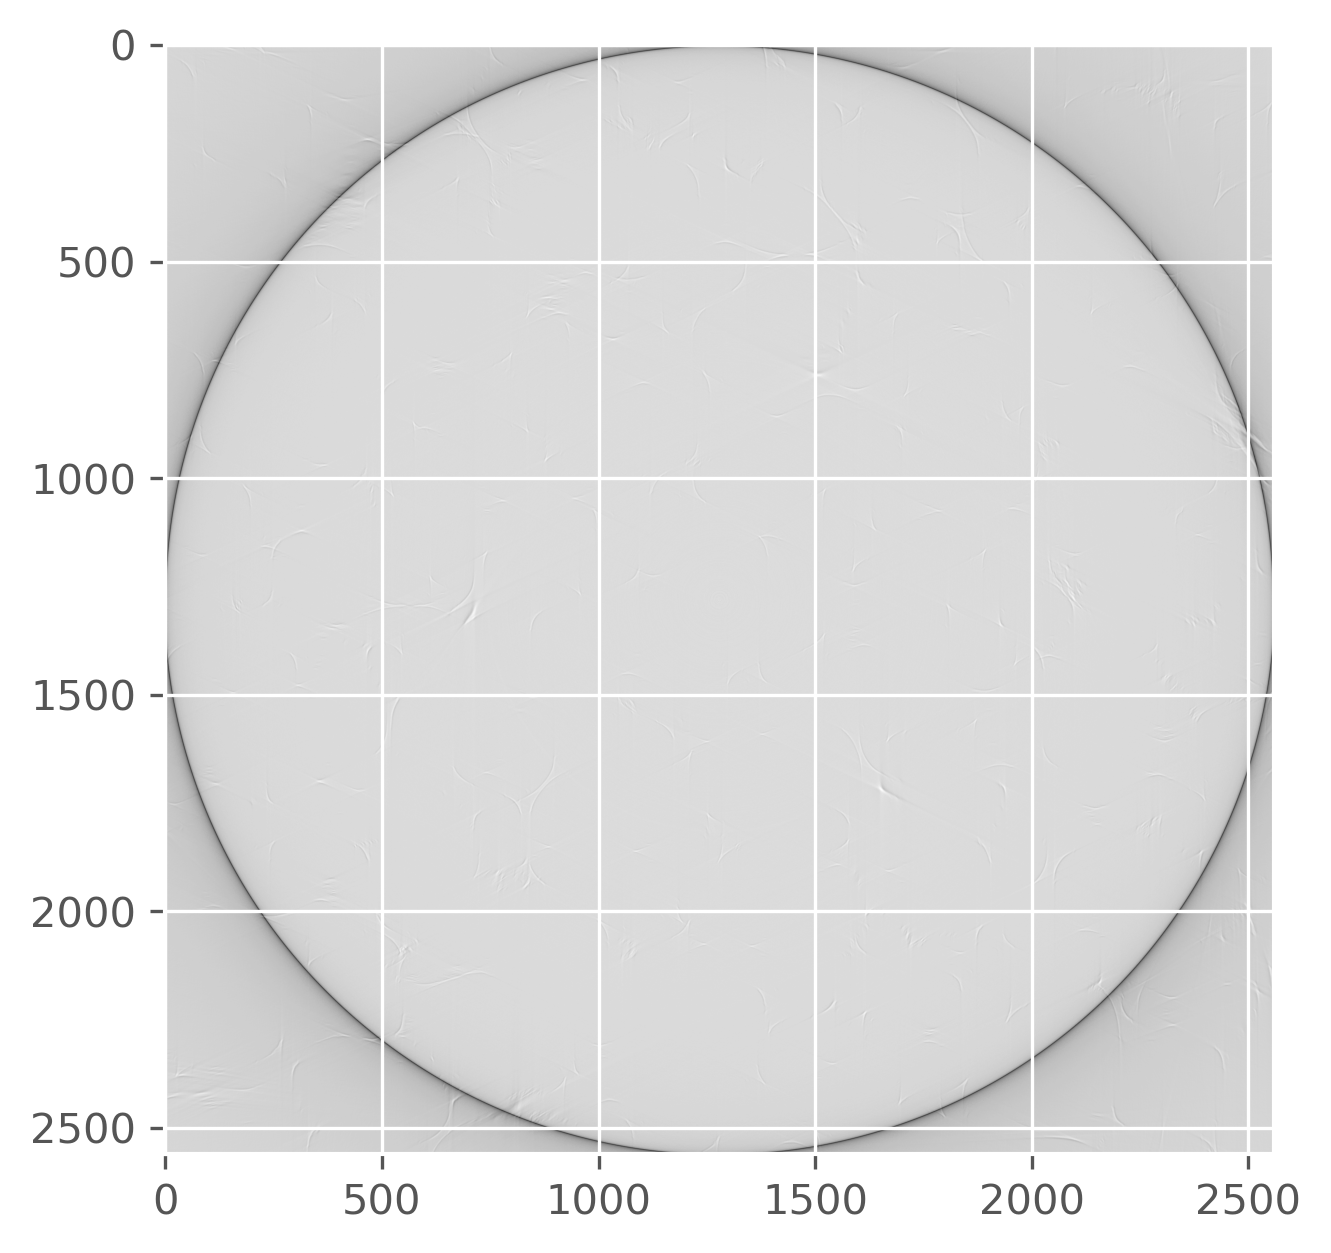

In [112]:
plt.imshow(recon[recon_slice,:,:].squeeze(), cmap='Greys')

## Post-processing
### Apply circular mask

In [54]:
recon = tomopy.circ_mask(recon,
                         axis=0,
                         ratio=0.9,
                         ncore=ncore)

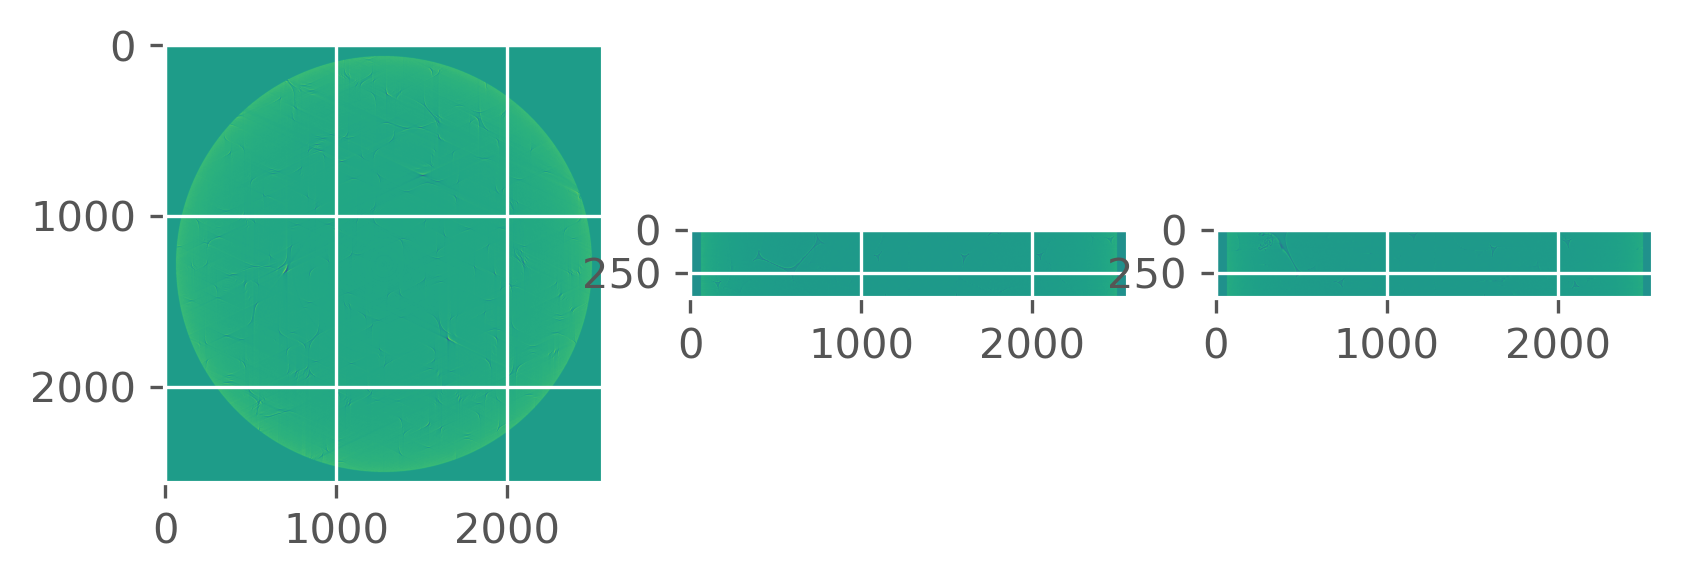

In [114]:
ru.plot_midplanes(recon)

### Ring artefact correction
Removes ring artefacts in the reconstruction domain

`tomopy.misc.corr.remove_ring(rec, center_x=None, center_y=None, thresh=300.0, thresh_max=300.0, thresh_min=-100.0, theta_min=30, rwidth=30, int_mode='WRAP', ncore=None, nchunk=None, out=None)`


In [34]:
recon = tomopy.misc.corr.remove_ring(recon)

In [32]:
recon = tomopy.misc.corr.remove_ring(recon,
                                     center_x=None,
                                     center_y=None,
                                     thresh=300.0,
                                     thresh_max=300.0,
                                     thresh_min=-100.0,
                                     theta_min=30,
                                     rwidth=30,
                                     int_mode='WRAP')

In [ ]:
plt.imshow(recon[:, 300, :], cmap='gray')
plt.show()

#### Apply again circular mask

In [79]:
recon = tomopy.circ_mask(recon, axis=0, ratio=0.95, val=-0.006)

### Scale to 0-255 (`uint8`)
The uint8 GV range for output slices can cover the full float32 range or be selected based on the 3D data histogram

In [77]:
subset_step = 20

In [78]:
recon_subset = recon[0::subset_step, 0::subset_step, 0::subset_step]

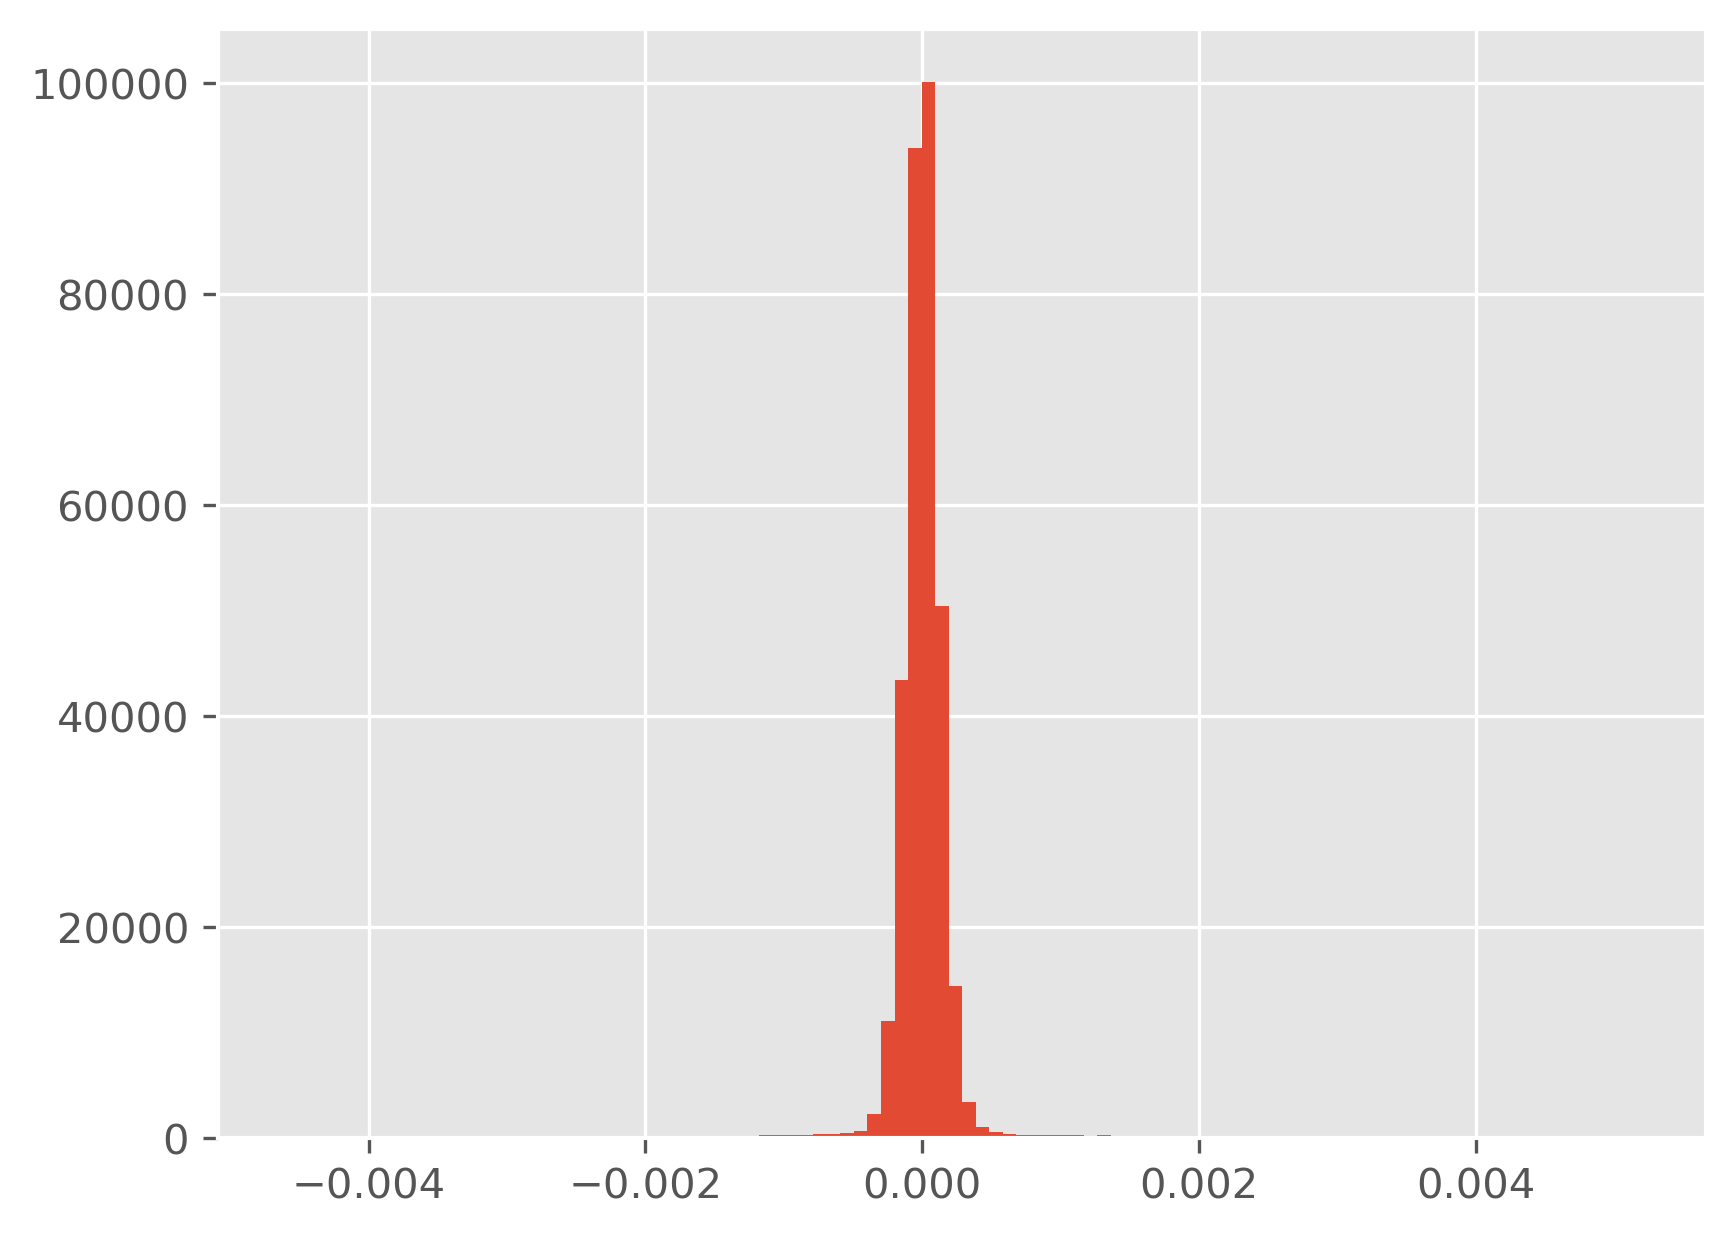

In [79]:
plt.hist(recon_subset.ravel(), bins=100)
plt.show()

In [ ]:
# uint8 GV range from data histogram (0.01 and 0.99 quantiles)
[range_min, q_95] = np.quantile(recon_subset.ravel(), [0.01, 0.99])
range_max = q_95 - range_min
print(range_min, range_max)

-7.854273877455853e-05 0.00048216310227871894


In [ ]:
# uint8 GV range as MIN and MAX of 3D data
range_min = np.nanmin(recon)
range_max = np.nanmax(recon)
range_max = range_max - range_min

In [80]:
range_min = -0.0006
range_max = 0.0006

In [ ]:
recon_uint8[recon_uint8 < 0] = 0

In [ ]:
recon_uint8[recon_uint8 > 255] = 255

In [96]:
# apply again circ mask
recon_uint8 = tomopy.circ_mask(recon_uint8, axis=0, ratio=0.95)

In [81]:
recon_uint8 = ru.touint(recon, 'uint8', [range_min, range_max])

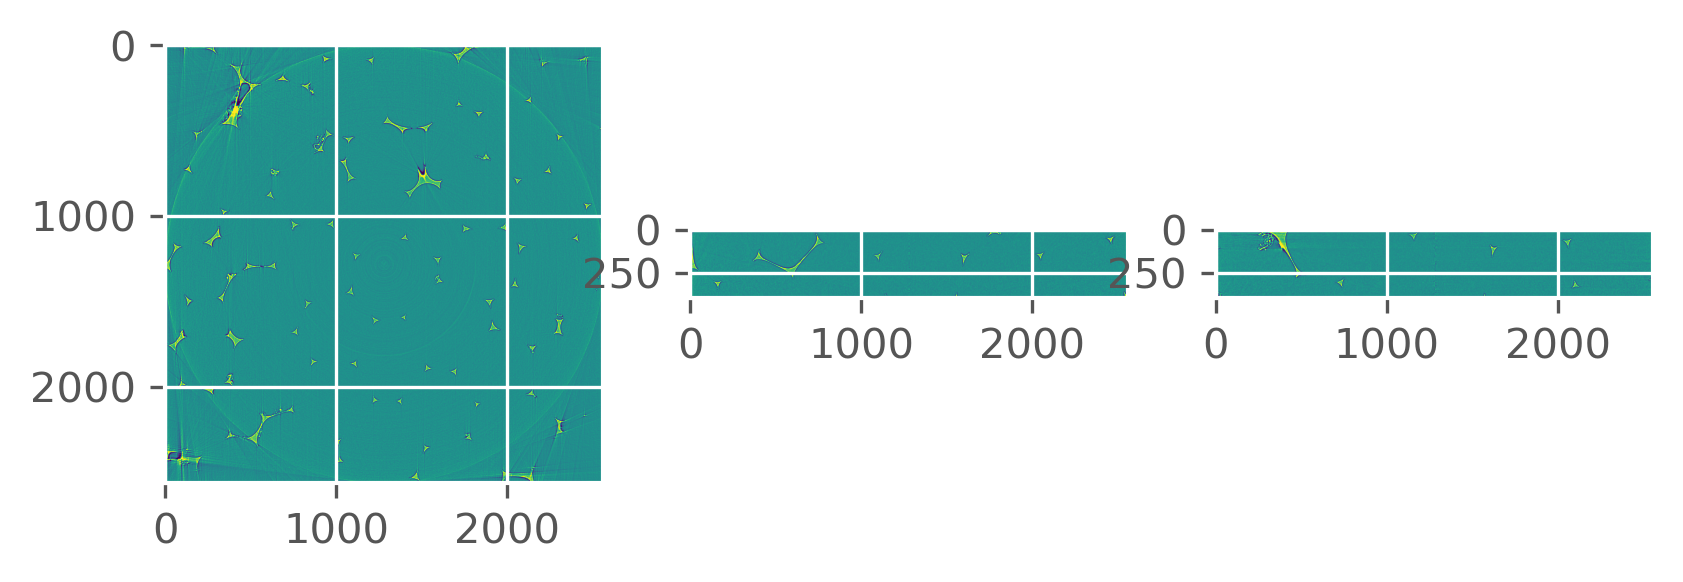

In [82]:
ru.plot_midplanes(recon_uint8)

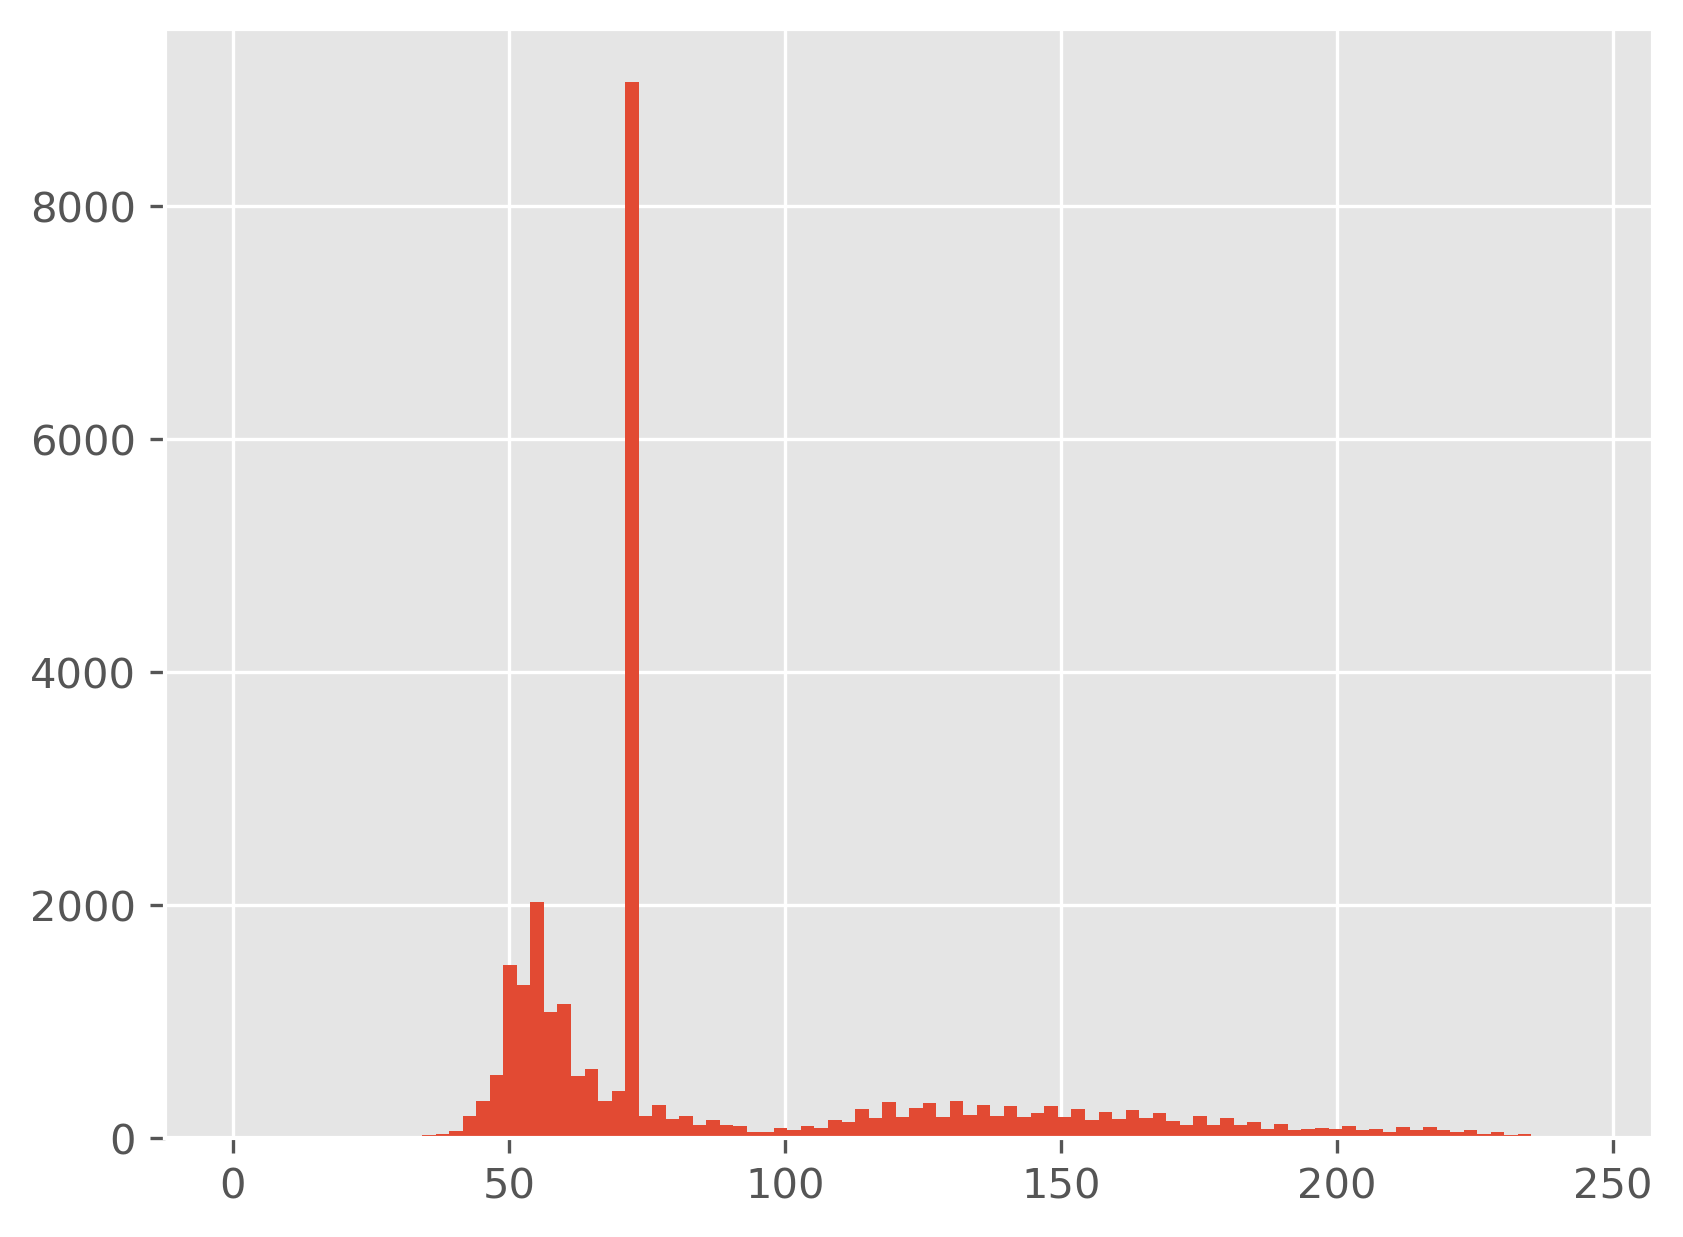

In [88]:
plt.hist(recon_uint8[0::100, 0::100, 0::100].round().ravel(), bins=100)
plt.show()

## Write recon dataset
### Write output tiff stack as `uint8`

In [115]:
recon_dir = "/home/beats/Data/plastic_foam/recon_fbp/"

In [ ]:
# fileout = recon_dir_8bit+'slice.tiff'
fileout = recon_dir+'slice.tiff'
# fileout = '/home/beats/Data/tmp/slice.tiff'
dxchange.writer.write_tiff_stack(recon_uint8,
                                 fname=fileout,
                                 dtype='uint8',
                                 axis=0,
                                 digit=4,
                                 start=0,
                                 overwrite=True)

### Write output tiff stack as `float32`

In [16]:
fileout = recon_dir+'slice.tiff'
dxchange.writer.write_tiff_stack(projs, fname=fileout, axis=0, digit=4, start=0, overwrite=True)

#### Open virtual stack in ImageJ

In [75]:
os.system(Fiji_exe_stack + fileout + ' &')

0

OpenJDK 64-Bit Server VM warning: ignoring option PermSize=128m; support was removed in 8.0
OpenJDK 64-Bit Server VM warning: Using incremental CMS is deprecated and will likely be removed in a future release
